# Utils

In [1]:
!pip install scikit-learn
!pip install pandas
!pip install optuna
!pip install matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
import numpy as np
import optuna as op
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def accuracy_plot(k_neighbours, train_data, test_data):
    plt.plot(k_neighbours, train_data)
    plt.plot(k_neighbours, test_data)
    plt.legend(('Train ', 'Test'))
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Neighbours / Radius')
    plt.grid(True)
    plt.show()

## Metrics

In [4]:
def euclidean_metric(a: np.array, b: np.array):
    return distance.minkowski(a, b, 2)


def chebyshev_distance(a: np.array, b: np.array):
    return np.max(np.abs(a - b))


def minkowski_metric(a: np.array, b: np.array, p: int):
    return distance.minkowski(a, b, p)


def cosine_metric(a: np.array, b: np.array):
    return 1 - cosine_similarity(a.reshape(1, -1), b.reshape(1, -1)).item(0)


metrics_map = {'euclidean': euclidean_metric, 'chebyshev': chebyshev_distance, 'cosine': cosine_metric}

## Kernels

In [5]:
def uniform(u: np.array):
    return np.multiply(u, 0.5) * (np.abs(u) < 1.0)


def triangular(u: np.array):
    return (1 - np.abs(u)) * (np.abs(u) < 1.0)


def epanechnikov(u: np.array):
    return 3.0 / 4.0 * (1 - np.power(u, 2)) * (np.abs(u) < 1.0)


def gaussian(u: np.array):
    return 1.0 / np.sqrt(2.0 * np.pi) * np.exp(-np.power(u, 2) / 2.0)


kernels_map = {'uniform': uniform, 'triangular': triangular, 'epanechnikov': epanechnikov, 'gaussian': gaussian}

## Windows

In [6]:
windows = ['var', 'fixed']

# Data preprocessing
Dataset: Moscow apartment listing with 4 price classes

In [7]:
df = pd.read_csv('csv/apartments.csv')[:1000]
df

,class,repair,year_built_empty,house_age,closest_subway,dist_to_subway,sg,lat,lon,subway_dist_to_center,...,subway_offers,address_offers,rooms,footage,floor,max_floor,first_floor,last_floor,AO,hm
0,1,3,0,42,59,960,0.0,55.609009,37.734632,17166,...,5,1.0,1,39.4,11,12,0,0,2,0
1,0,2,0,43,59,802,0.0,55.608760,37.741936,17166,...,9,1.0,1,35.6,2,9,0,0,2,0
2,2,2,0,43,59,638,0.0,55.610207,37.742495,17166,...,9,2.0,2,53.0,5,12,0,0,2,0
3,1,2,0,43,59,929,0.0,55.624017,37.740373,17166,...,5,1.0,2,44.1,8,9,0,0,2,0
4,1,2,0,43,59,785,0.0,55.609107,37.740430,17166,...,5,1.0,2,44.2,6,9,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,2,0,50,98,583,0.0,55.884098,37.667606,15384,...,17,1.0,2,44.9,7,14,0,0,5,3
996,2,3,0,50,98,954,0.0,55.888610,37.646286,15384,...,20,1.0,2,44.0,1,14,1,0,5,3
997,2,4,0,38,98,1912,0.0,55.894429,37.633050,15384,...,20,2.0,2,53.4,12,12,0,1,5,0
998,2,2,0,15,98,1668,0.0,55.879890,37.639187,15384,...,29,1.0,2,55.0,12,14,0,0,5,2


## Data normalization

<Axes: >

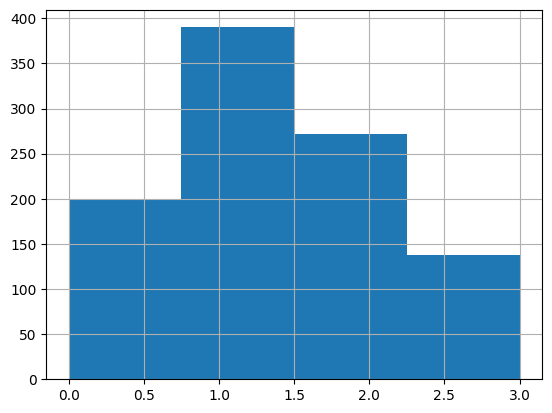

In [8]:
y = df['class'].values
X = StandardScaler().fit_transform(df.drop(columns=['class']).values)
df['class'].hist(bins=4)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (800, 20) (800,)
Test set: (200, 20) (200,)


# My K-Nearest Neighbours Classifier

In [10]:
class MyKNeighborsClassifier:
    lib_model = None
    window = 'var'
    probability = {}
    Y_train = []
    classes = []

    def __init__(self, metr: callable, wind: str):
        self.lib_model = NearestNeighbors(metric=metr)
        self.window = wind

    def fit(self, x_train, Y_train):
        assert len(x_train) == len(Y_train)
        self.lib_model.fit(x_train)
        self.Y_train = Y_train
        self.classes = np.unique(Y_train)
        return self

    def forecast(self,
                 value,
                 kern,
                 k_neighbours: int = 3, radius: float = 1.0,
                 wghts=None):
        if wghts is None:
            wghts = np.ones(len(self.Y_train))

        x = [value]
        match self.window:
            case 'fixed':
                divisor = radius
                if kern == gaussian:
                    radius = np.inf
                neigh_dist, neigh_ind = self.lib_model.radius_neighbors(x, radius, return_distance=True)
                if len(neigh_dist) == 0:
                    raise RuntimeError('No neighbours found in given radius')
                neigh_ind = neigh_ind[0]
                neigh_dist = neigh_dist[0]
            case 'var':
                neigh_dist, neigh_ind = self.lib_model.kneighbors(x, k_neighbours + 1, return_distance=True)
                neigh_ind = neigh_ind[0][:-1]
                neigh_dist = neigh_dist[0]
                divisor = neigh_dist[-1]
                neigh_dist = neigh_dist[:-1]
            case _:
                raise RuntimeError

        modified_dist = kern(neigh_dist / divisor) * wghts[neigh_ind]
        classes = self.Y_train[neigh_ind]
        class_count_map = {}
        for i in range(len(classes)):
            if classes[i] not in class_count_map:
                class_count_map[classes[i]] = 0
            class_count_map[classes[i]] += modified_dist[i]
        sum_dist = sum(modified_dist)

        for item in class_count_map.items():
            self.probability[item[0]] = item[1] / sum_dist

        buf = sorted(class_count_map.items(), key=lambda v: v[1], reverse=True)

        if len(buf) == 0:
            return 0

        return buf[0][0]

    def predict(self,
                x_test,
                kern,
                k_neighbours: int = 3, radius: float = 1.0,
                wghts=None):
        forecasts = []
        for value in x_test:
            forecasts.append(self.forecast(value, kern, k_neighbours, radius, wghts))
        return forecasts

    def get_probability(self, value):
        return self.probability.get(value, 0.0)

## Hyperparameters optimization

In [11]:
def objective(trial: op.Trial):
    metr = trial.suggest_categorical('metric', metrics_map.keys())
    metr = metrics_map[metr]

    kern = trial.suggest_categorical('kernel', kernels_map.keys())
    kern = kernels_map[kern]

    wind = trial.suggest_categorical('window', windows)

    x_train, x_test, Y_train, Y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    KNN_model = MyKNeighborsClassifier(metr, wind)
    KNN_model.fit(x_train, Y_train)

    match wind:
        case 'var':
            k = trial.suggest_int('neighbours', 2, 20)
            yhat = KNN_model.predict(x_test, kern, k_neighbours=k)
        case 'fixed':
            h = trial.suggest_float('radius', 1e-3, 2)
            yhat = KNN_model.predict(x_test, kern, radius=h)
        case _:
            raise RuntimeError

    return balanced_accuracy_score(Y_test, yhat)


study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1, catch=RuntimeError, gc_after_trial=True, show_progress_bar=False)

window = study.best_params['window']
metric = metrics_map[study.best_params['metric']]
kernel = kernels_map[study.best_params['kernel']]

[I 2024-05-26 13:05:28,348] A new study created in memory with name: no-name-70a41d79-e8a5-4985-b701-1f0ef3a22415
[I 2024-05-26 13:05:31,970] Trial 1 finished with value: 0.2668247515808492 and parameters: {'metric': 'euclidean', 'kernel': 'epanechnikov', 'window': 'fixed', 'radius': 0.36581241564187195}. Best is trial 1 with value: 0.2668247515808492.
[I 2024-05-26 13:05:32,675] Trial 4 finished with value: 0.4497908566042182 and parameters: {'metric': 'euclidean', 'kernel': 'uniform', 'window': 'fixed', 'radius': 1.9598850577743636}. Best is trial 4 with value: 0.4497908566042182.
[I 2024-05-26 13:05:50,034] Trial 6 finished with value: 0.556051411963395 and parameters: {'metric': 'chebyshev', 'kernel': 'gaussian', 'window': 'var', 'neighbours': 11}. Best is trial 6 with value: 0.556051411963395.
[I 2024-05-26 13:05:50,178] Trial 0 finished with value: 0.6483936216173756 and parameters: {'metric': 'chebyshev', 'kernel': 'triangular', 'window': 'var', 'neighbours': 19}. Best is trial 

### Best hyperparameters

In [12]:
print('Best window:', window)
print('Best metric:', study.best_params['metric'])
print('Best kernel:', study.best_params['kernel'])

Best window: var
Best metric: euclidean
Best kernel: epanechnikov


## Different K comparison

In [13]:
def get_accuracy_by_k(K: int,
                      metr: callable,
                      kern: callable,
                      wind: str):
    train_ac = np.zeros(K - 1)
    test_ac = np.zeros(K - 1)

    KNN_model = MyKNeighborsClassifier(metr=metr, wind=wind)
    KNN_model.fit(X_train, y_train)

    for k in range(1, K):
        yhat = KNN_model.predict(X_train, kern, k_neighbours=k)
        train_ac[k - 1] = balanced_accuracy_score(y_train, yhat)

        yhat = KNN_model.predict(X_test, kern, k_neighbours=k)
        test_ac[k - 1] = balanced_accuracy_score(y_test, yhat)

    return train_ac, test_ac

def get_accuracy_by_radius(K: int,
                      metr: callable,
                      kern: callable,
                      wind: str):
    train_ac = np.zeros(K - 1)
    test_ac = np.zeros(K - 1)

    KNN_model = MyKNeighborsClassifier(metr=metr, wind=wind)
    KNN_model.fit(X_train, y_train)

    for k in range(1, K):
        rad = 0.7 + 0.05 * k
        yhat = KNN_model.predict(X_train, kern, radius=rad)
        train_ac[k - 1] = balanced_accuracy_score(y_train, yhat)

        yhat = KNN_model.predict(X_test, kern, radius=rad)
        test_ac[k - 1] = balanced_accuracy_score(y_test, yhat)

    return train_ac, test_ac

In [14]:
max_k = 20
if window == 'var':
    train_accuracy, test_accuracy = get_accuracy_by_k(max_k, metric, kernel, window)
else:
    train_accuracy, test_accuracy = get_accuracy_by_radius(max_k, metric, kernel, window)

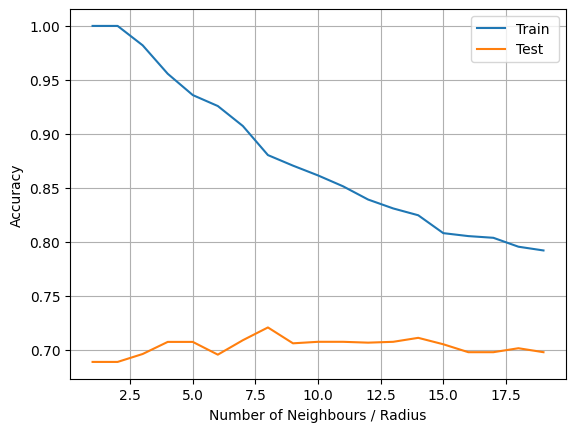

In [15]:
accuracy_plot(range(1, max_k), train_accuracy, test_accuracy)

## Anomaly detection with LOWESS

In [16]:
def low(metr: callable,
        kern: callable,
        wind: str):
    model = MyKNeighborsClassifier(metr=metr, wind=wind)
    weights = []
    for i in range(len(X_train)):
        x_train = np.delete(X_train, i, axis=0)
        Y_train = np.delete(y_train, i, axis=0)
        model.fit(x_train, Y_train)

        model.forecast(X_train[i], kern, k_neighbours=12)
        weight = model.get_probability(y_train[i])
        weights.append(weight)

    model.fit(X_train, y_train)
    yhat = model.predict(X_test, kern, k_neighbours=12)
    print("Ones", balanced_accuracy_score(y_test, yhat))
    yhat = model.predict(X_test, kern, k_neighbours=12, wghts=gaussian(np.array(weights)))
    print("Gaussian", balanced_accuracy_score(y_test, yhat))
    yhat = model.predict(X_test, kern, k_neighbours=12, wghts=uniform(np.array(weights)))
    print("Uniform", balanced_accuracy_score(y_test, yhat))


low(metric, kernel, window)

Ones 0.7064075630252101
Gaussian 0.7064075630252101
Uniform 0.6665791316526611


# K-Nearest Neighbours Classifier from sklearn library

## Hyperparameters optimization

In [18]:
def objective2(trial: op.Trial):
    metr = trial.suggest_categorical('metric', metrics_map.keys())
    metr = metrics_map[metr]

    k = trial.suggest_int('neighbour', 2, 20)

    x_train, x_test, Y_train, Y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    KNN_model = KNeighborsClassifier(n_neighbors=k, metric=metr)
    KNN_model.fit(x_train, Y_train)

    yhat = KNN_model.predict(x_test)
    return balanced_accuracy_score(Y_test, yhat)


study = op.create_study(direction='maximize')
study.optimize(objective2, n_trials=100, n_jobs=-1, catch=RuntimeError, gc_after_trial=True, show_progress_bar=False)

metric = metrics_map[study.best_params['metric']]

[I 2024-05-26 13:21:28,361] A new study created in memory with name: no-name-fad46a5f-7454-4c67-9b3e-def5d325e0a1
[I 2024-05-26 13:22:04,243] Trial 0 finished with value: 0.5500962255999372 and parameters: {'metric': 'chebyshev', 'neighbour': 9}. Best is trial 0 with value: 0.5500962255999372.
[I 2024-05-26 13:22:04,384] Trial 2 finished with value: 0.6249901810612308 and parameters: {'metric': 'cosine', 'neighbour': 2}. Best is trial 2 with value: 0.6249901810612308.
[I 2024-05-26 13:22:04,391] Trial 7 finished with value: 0.567991241506618 and parameters: {'metric': 'chebyshev', 'neighbour': 5}. Best is trial 2 with value: 0.6249901810612308.
[I 2024-05-26 13:22:04,474] Trial 3 finished with value: 0.5989356270374298 and parameters: {'metric': 'cosine', 'neighbour': 20}. Best is trial 2 with value: 0.6249901810612308.
[I 2024-05-26 13:22:04,679] Trial 5 finished with value: 0.515651388397942 and parameters: {'metric': 'chebyshev', 'neighbour': 16}. Best is trial 2 with value: 0.62499

### Best hyperparameters

In [20]:
print('Best metric:', study.best_params['metric'])

Best metric: cosine


## Different K comparison

In [21]:
def get_accuracy_for_range(K: int,
                           metr: callable):
    train_ac = np.zeros(K - 1)
    test_ac = np.zeros(K - 1)

    for k in range(1, K):
        KNN_model = KNeighborsClassifier(metric=metr, n_neighbors=k)
        KNN_model.fit(X_train, y_train)

        yhat = KNN_model.predict(X_train)
        train_ac[k - 1] = balanced_accuracy_score(y_train, yhat)

        yhat = KNN_model.predict(X_test)
        test_ac[k - 1] = balanced_accuracy_score(y_test, yhat)

    return train_ac, test_ac


max_k = 20
train_accuracy, test_accuracy = get_accuracy_for_range(max_k, metric)

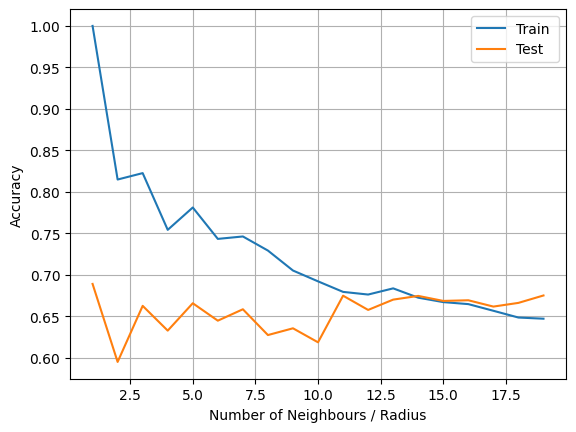

In [22]:
accuracy_plot(range(1, max_k), train_accuracy, test_accuracy)

## Anomaly detection with LOWESS

In [24]:
def low2(best_metric):
    model = KNeighborsClassifier(n_neighbors=12, metric=best_metric)
    weights = []
    min_class = np.unique(y_train)[0]
    for i in range(len(X_train)):
        x_train = np.delete(X_train, i, axis=0)
        Y_train = np.delete(y_train, i, axis=0)
        model.fit(x_train, Y_train)

        yhat = model.predict_proba([X_train[i]])[0]
        weight = yhat[y_train[i] - min_class]
        weights.append(weight)
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    print("Ones", balanced_accuracy_score(y_test, yhat))


low2(metric)

Ones 0.6576505602240896
